In [1]:
import pandas as pd
import os
import sys
import numpy as np
import ast
import geopandas as gpd

from urllib.request import urlopen
from zipfile import ZipFile

import requests
from io import StringIO

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.dates import MonthLocator, DateFormatter

from shapely.geometry import Point

## Load SC tract and county shapefiles

Len(tract_gdf): 1097


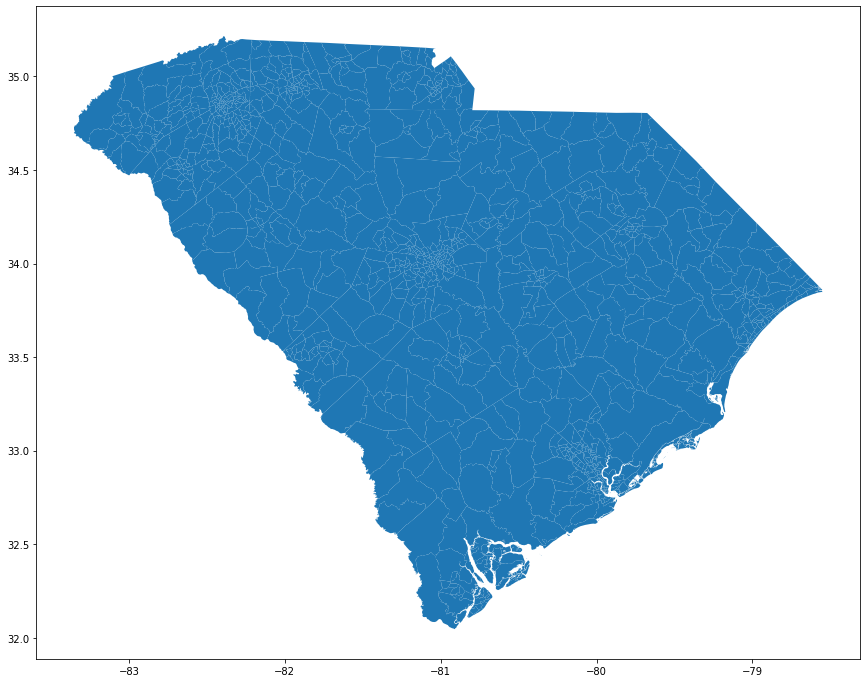

In [2]:
plt.rcParams['figure.figsize'] = (15, 12) #set default figure size

shapefile_url = r'https://github.com/GIBDUSC/Twitter-derived-human-mobility/raw/master/sc_tract.zip'

zipresp = urlopen(shapefile_url)
tempzip = open("tempfile.zip", "wb")
tempzip.write(zipresp.read())
tempzip.close()
zf = ZipFile("tempfile.zip")
zf.extractall(path = 'sc_tract.shp')
zf.close()

tract_gdf = gpd.read_file(r'sc_tract.shp')
#tract_gdf.head()
#SC_gdf.plot()
print(f"Len(tract_gdf): {len(tract_gdf)}")
tract_gdf.count
tract_gdf.plot()


In [91]:
#tract_gdf.head()

Len(county_gdf): 3221


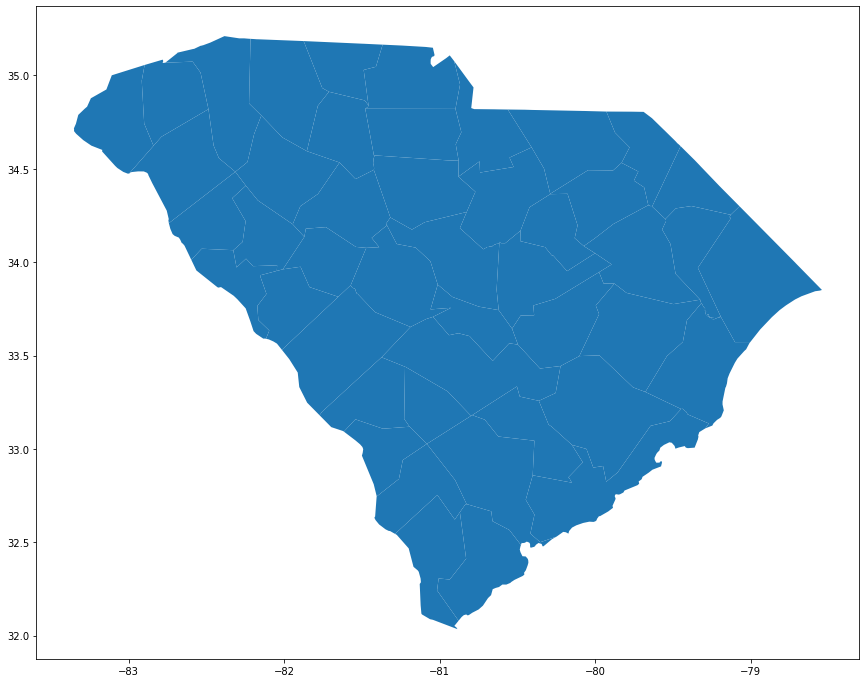

In [3]:
shapefile_url = r'https://github.com/GIBDUSC/test/raw/master/us_counties.zip'

zipresp = urlopen(shapefile_url)
tempzip = open("tempfile.zip", "wb")
tempzip.write(zipresp.read())
tempzip.close()
zf = ZipFile("tempfile.zip")
zf.extractall(path = 'us_counties.shp')
zf.close()

county_gdf = gpd.read_file(r'us_counties.shp')
print(f"Len(county_gdf): {len(county_gdf)}")
county_gdf.count
#county_gdf.plot(figsize=(20, 10))

county_gdf['fips'] = county_gdf['FIPS'].str[2:]
county_gdf =  county_gdf.loc[county_gdf.STATE=="45"]
county_gdf.plot()

In [90]:
#county_gdf.head()

## Load and prepare data

In [4]:
census = r'US_tract_for_residential_segregation.csv'
us_df = pd.read_csv(census)
df =  us_df.loc[us_df.StateAbbreviation=="SC"]
df

,FIPS,CountyFIPS,StateAbbreviation,AreaTotal,TotalPopulation,White,BlackAfricanAmerican,AmericanIndianAlaskaNative,Asian,NativeHawaiianOtherPacificIslander,SomeOtherRace,TwoOrMoreRaces
58807,45001950100,45001,SC,48.778880,2981,2513,401,0,0,0,11,56
58808,45001950200,45001,SC,74.144420,4310,3397,693,0,79,0,11,130
58809,45001950300,45001,SC,101.494400,3464,3337,126,0,0,0,0,1
58810,45001950400,45001,SC,77.696790,5901,3940,1835,0,0,0,10,116
58811,45001950500,45001,SC,110.513600,5214,2580,2569,15,0,0,5,45
...,...,...,...,...,...,...,...,...,...,...,...,...
59905,45091061707,45091,SC,11.017450,10563,8947,929,83,177,0,153,274
59906,45091061708,45091,SC,10.567350,5910,5112,614,16,41,0,38,89
59907,45091061801,45091,SC,4.560665,2887,1955,770,0,22,0,39,101
59908,45091061802,45091,SC,9.449888,5331,4308,290,120,334,0,172,107


In [5]:
df_county = df.groupby(['CountyFIPS']).agg(AreaTotalSum=('AreaTotal','sum'),
                                           TotalPopulationSum=('TotalPopulation','sum'),
                                           WhiteSum=('White','sum'),
                                           BlackAfricanAmericanSum=('BlackAfricanAmerican','sum')
                                          )
df_county.head()

,AreaTotalSum,TotalPopulationSum,WhiteSum,BlackAfricanAmericanSum
CountyFIPS,,,,
45001,511.980980,24627,17221,6804
45003,1080.169046,168301,118946,42002
45005,412.416950,9024,2108,6664
45007,755.747666,198064,157968,31183
45009,395.562190,14376,5237,8786


In [6]:
df_sc = pd.merge(df, df_county, left_on='CountyFIPS', right_on="CountyFIPS",how="outer")
df_sc.head()
df_sc.to_csv("df_sc.csv")

## Compute and visualize the Index of Dissimilarity
https://en.wikipedia.org/wiki/Index_of_dissimilarity

In [7]:
diss = df_sc.groupby(['CountyFIPS'])["White", "BlackAfricanAmerican","WhiteSum", "BlackAfricanAmericanSum"].apply(
    lambda x : 0.5*abs(x.BlackAfricanAmerican/x.BlackAfricanAmericanSum - x.White/x.WhiteSum).sum()
).reset_index(name='Dissimilarity')

diss['CountyFIPS'] = diss['CountyFIPS'].astype(str)
county_gdf['fips'] = county_gdf['fips'].astype(str)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [8]:
joined_gdf = pd.merge(county_gdf, diss, left_on='fips', right_on="CountyFIPS")

(1123193.2701167678, 1617387.93920426, 1091326.4585263575, 1466571.0265515575)

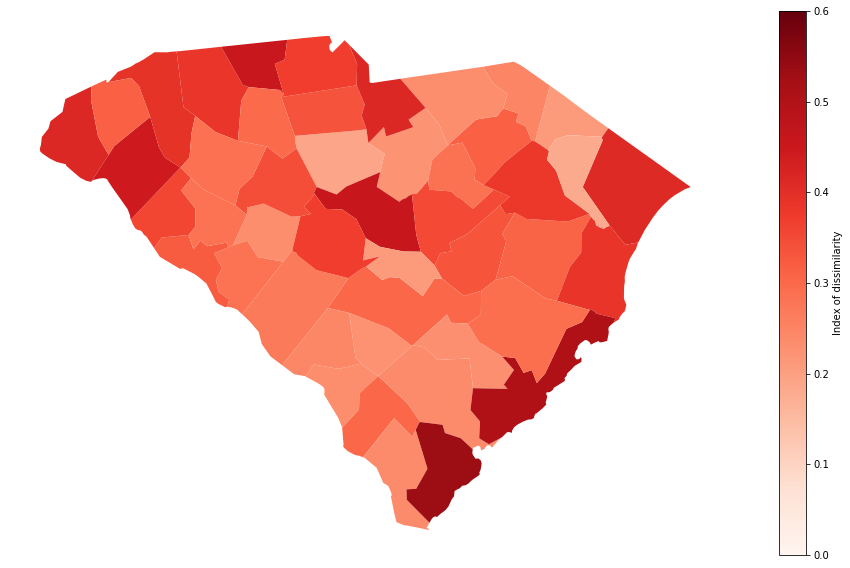

In [9]:
#joined_gdf.to_crs(5070).plot(column='Dissimilarity', cmap='Reds',scheme='quantiles',legend=True,figsize=(20, 10)).axis("off")
joined_gdf.to_crs(5070).plot(column='Dissimilarity', vmin=0, vmax=0.6, cmap='Reds', legend_kwds={'orientation':'vertical',"label":'Index of dissimilarity'},legend=True,figsize=(20, 10)).axis("off")